**PREPARAÇÃO DO AMBIENTE E TRATAMENTO DOS DADOS**

In [2]:
#Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
sex_offenders = pd.read_csv('/content/drive/MyDrive/estatistica/Sex_Offenders.csv')
crimes = pd.read_csv('/content/drive/MyDrive/estatistica/Crimes_2001_to_Present_Cut_Version.csv', low_memory=False)

In [4]:
# -- TRATAMENTO DOS DADOS -- #

sex_offenders_colunas_criticas = ['BIRTH DATE', 'BLOCK', 'GENDER', 'RACE']
sex_offenders.dropna(subset=sex_offenders_colunas_criticas, inplace=True)

#Remove community area inválida
crimes['Community Area'] = pd.to_numeric(crimes['Community Area'], errors='coerce')
crimes = crimes[crimes['Community Area'] > 0].copy()

crimes_colunas_criticas = ['Date', 'Block', 'Community Area', 'Primary Type']
crimes.dropna(subset=crimes_colunas_criticas, inplace=True)
sex_offenders['GENDER'] = sex_offenders['GENDER'].astype('category')
sex_offenders['RACE'] = sex_offenders['RACE'].astype('category')
sex_offenders['BIRTH DATE'] = pd.to_datetime(sex_offenders['BIRTH DATE'], format='%m/%d/%Y', errors='coerce')
sex_offenders['VICTIM MINOR'] = sex_offenders['VICTIM MINOR'].astype('category')
sex_offenders['BLOCK'] = sex_offenders['BLOCK'].astype('category')
crimes['Date'] = pd.to_datetime(crimes['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
crimes['Primary Type'] = crimes['Primary Type'].astype('category')
crimes['Block'] = crimes['Block'].astype('category')
crimes['IUCR'] = crimes['IUCR'].astype('category')
crimes['Location Description'] = crimes['Location Description'].astype('category')
crimes['District'] = crimes['District'].astype('category')
crimes['Community Area'] = crimes['Community Area'].astype('category')
print(sex_offenders.head())
print(sex_offenders.info())
print(sex_offenders.columns)
print(crimes.head())
print(crimes.info())



           LAST      FIRST               BLOCK GENDER   RACE BIRTH DATE  \
0      WILLIAMS      GLYNN  086XX S COLFAX AVE   MALE  BLACK 1962-07-03   
1  CHRISTIANSEN     DWIGHT  004XX N WABASH AVE   MALE  WHITE 1959-09-26   
2       VERDINO   LAWRENCE   054XX W BARRY AVE   MALE  WHITE 1957-09-26   
3     GASCOIGNE     DUSTIN    11XXX S STATE ST   MALE  WHITE 1987-09-17   
4       BARNETT  UNDERWOOD     014XX W 73RD ST   MALE  BLACK 1948-07-31   

   HEIGHT  WEIGHT VICTIM MINOR  
0     509     189            Y  
1     600     190            Y  
2     510     230            Y  
3     511     208            Y  
4     510     175            Y  
<class 'pandas.core.frame.DataFrame'>
Index: 3849 entries, 0 to 3864
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   LAST          3849 non-null   object        
 1   FIRST         3849 non-null   object        
 2   BLOCK         3849 non-null   category      


In [8]:
# Adiciona mapeamento de 'Community Area' no dataset 'Sex_offenders'

block_para_community = crimes.dropna(subset=['Community Area']).drop_duplicates(subset=['Block'])[['Block', 'Community Area']]
block_mapping = dict(zip(block_para_community['Block'], block_para_community['Community Area']))
sex_offenders['Community Area'] = sex_offenders['BLOCK'].map(block_mapping)
mapeamento_manual = {
        '12XXX S GREEN ST': 53.0,
        '11XXX S STATE ST': 49.0,
        '12XXX S LAFAYETTE AVE': 53.0,
        '11XXX S PERRY AVE': 49.0,
        '10XXX S LAFAYETTE AVE': 49.0,
        '10XXX S WABASH AVE': 49.0,
        '12XXX S WENTWORTH AVE': 53.0,
        '11XXX S EMERALD AVE': 49.0,
        '10XXX S AVENUE M': 52.0,
        '12XXX S WALLACE ST': 53.0,
        }
mapa_block_para_community = block_mapping | mapeamento_manual
sex_offenders['Community Area'] = sex_offenders['BLOCK'].map(mapa_block_para_community)
print(sex_offenders[['BLOCK', 'Community Area']].head())

                BLOCK  Community Area
0  086XX S COLFAX AVE            46.0
1  004XX N WABASH AVE             8.0
2   054XX W BARRY AVE            19.0
3    11XXX S STATE ST            49.0
4     014XX W 73RD ST            67.0


# Qual é a quantidade de criminosos sexuais em cada “Community Area”? Existe um padrão nessa distribuição?


Community Area
1.0     21
2.0     21
3.0     19
4.0     15
5.0      9
        ..
73.0    22
74.0     3
75.0     5
76.0     5
77.0    28
Name: count, Length: 76, dtype: int64


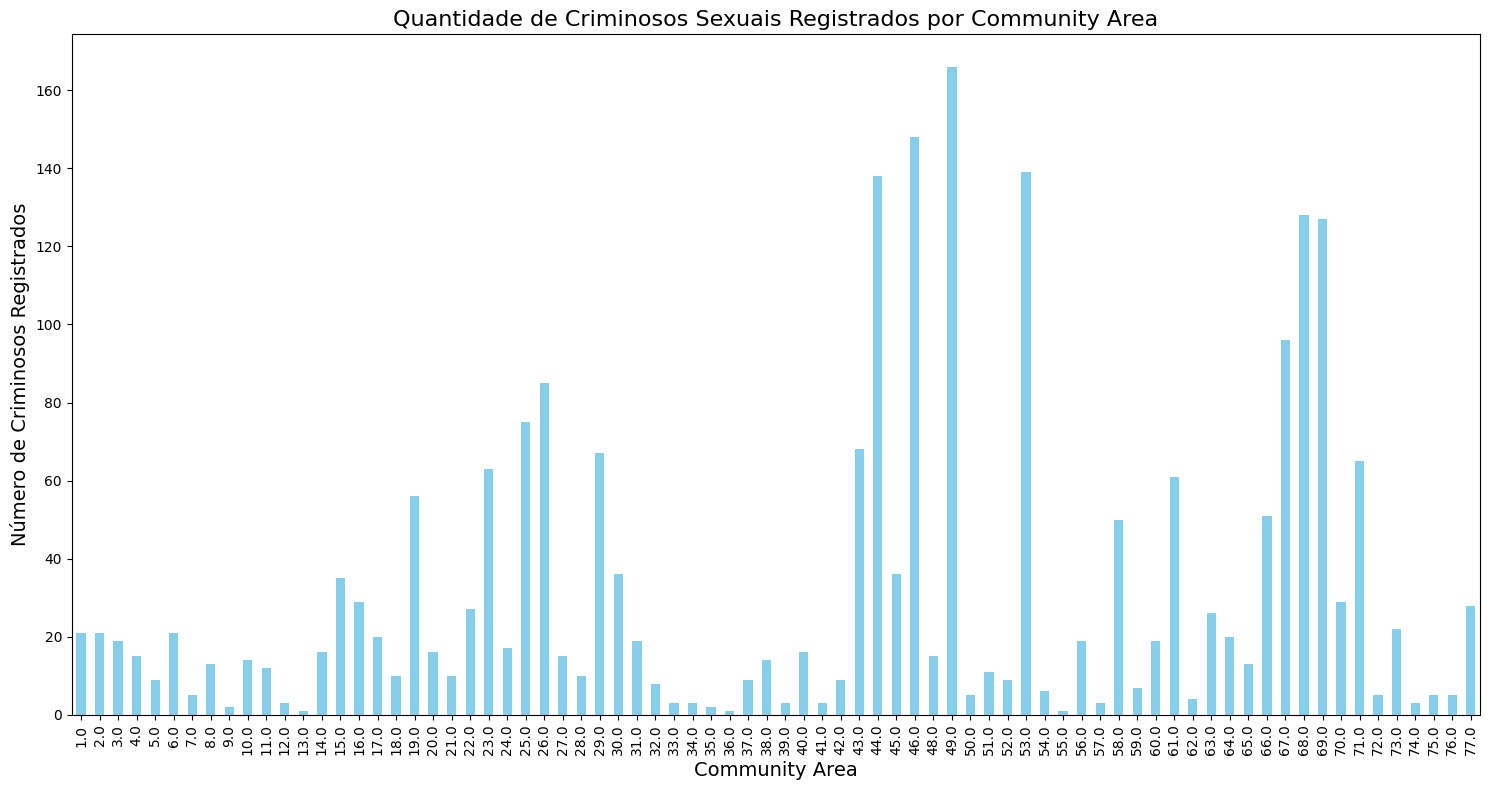

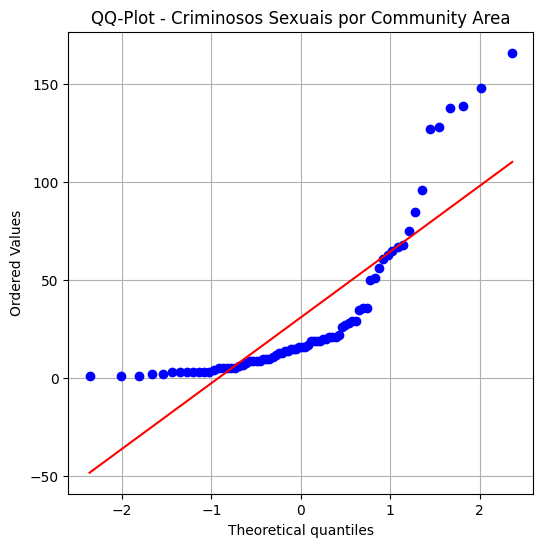


Teste de Normalidade (Shapiro-Wilk):
Estatística: 0.7146, p-valor: 7.365470863511371e-11

Resultado: Hipótese nula (H₀) reijeitada. A distribuição NÃO é normal.



In [53]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
import seaborn as sns

crimes_validos = crimes.dropna(subset=['Community Area'])
criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
print(criminosos_por_area)
#Gráfico
plt.figure(figsize=(15, 8))
criminosos_por_area.plot(kind='bar', color='skyblue')
plt.title("Quantidade de Criminosos Sexuais Registrados por Community Area", fontsize=16)
plt.xlabel("Community Area", fontsize=14)
plt.ylabel("Número de Criminosos Registrados", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
print()
#Verificação de normalidade da distribuição:
# QQ-Plot
plt.figure(figsize=(6, 6))
probplot(criminosos_por_area.values, dist="norm", plot=plt)
plt.title("QQ-Plot - Criminosos Sexuais por Community Area")
plt.grid(True)
plt.show()
print()
# Teste de Shapiro-Wilk
print("Teste de Normalidade (Shapiro-Wilk):")
stat, p_value = shapiro(criminosos_por_area.values)
print(f"Estatística: {stat:.4f}, p-valor: {p_value}")
print()

alpha = 0.05
if p_value < alpha:
    print("Resultado: Hipótese nula (H₀) reijeitada. A distribuição NÃO é normal.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada. A distribuição pode ser considerada normal.\n")

# Qual a idade dos criminosos sexuais registrados com vítima menor em relação aos registrados sem vítima menor?

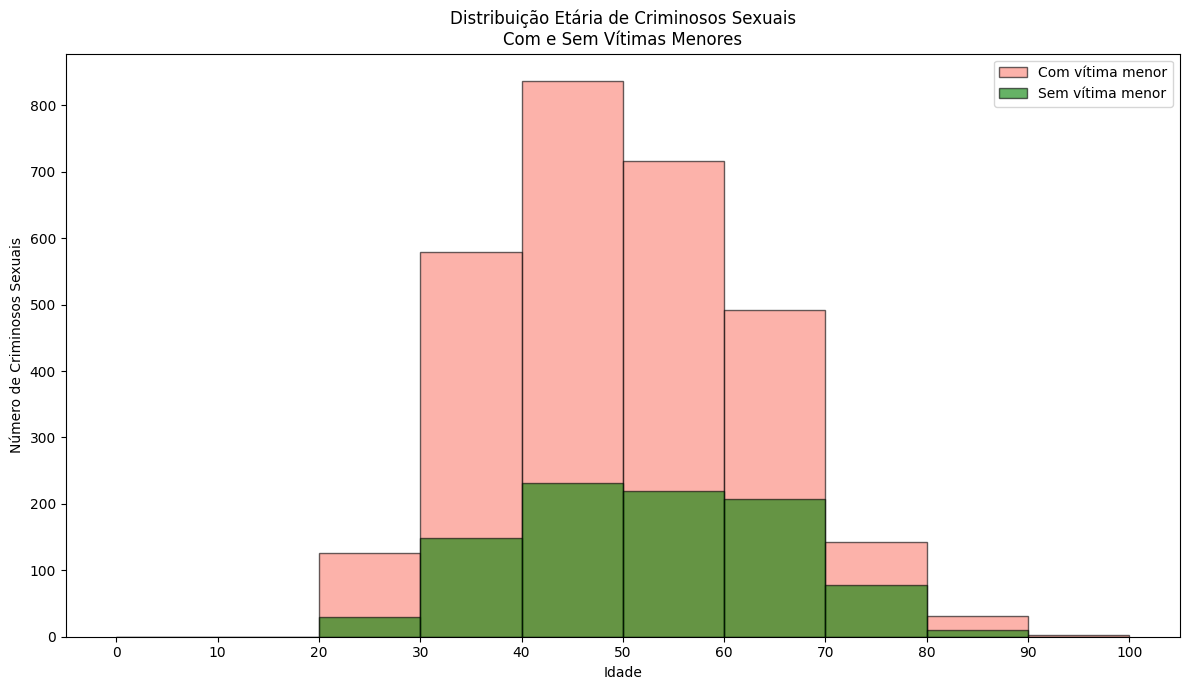


Tabela de Contingência (Faixa Etária x Vítima Menor):
VICTIM MINOR    N    Y
Faixa Etária          
20-29          29  126
30-39         148  579
40-49         231  836
50-59         220  716
60-69         208  492
70-79          78  142
80+            10   34

Teste do Qui-Quadrado:
Estatística Qui² = 39.412884890190725
p-valor = 5.940096604151543e-07
Graus de liberdade = 6
Resultado: Hipótese nula (H₀) rejeitada. Há evidências de associação entre faixa etária e o fato da vítima ser menor.



In [54]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Cálculo da idade dos criminosos registrados
data_atual = pd.to_datetime("today")
sex_offenders['IDADE'] = (data_atual - sex_offenders['BIRTH DATE']).dt.days // 365
print()
# Separação de criminosos onde 'VICTIM MINOR'== Y
criminosos_vitima_menor = sex_offenders[sex_offenders['VICTIM MINOR'] == 'Y']
# Separação de criminosos onde 'VICTIM MINOR'== N
criminosos_sem_vitima_menor = sex_offenders[sex_offenders['VICTIM MINOR'] == 'N']
# Histograma sobreposto dos grupos (com e sem vítima)
plt.figure(figsize=(12, 7))
plt.hist(criminosos_vitima_menor['IDADE'], bins=range(0, 101, 10),
         alpha=0.6, label='Com vítima menor', color='salmon', edgecolor='black')
plt.hist(criminosos_sem_vitima_menor['IDADE'], bins=range(0, 101, 10),
         alpha=0.6, label='Sem vítima menor', color='green', edgecolor='black')
plt.title('Distribuição Etária de Criminosos Sexuais\nCom e Sem Vítimas Menores')
plt.xlabel('Idade')
plt.ylabel('Número de Criminosos Sexuais')
plt.xticks(range(0, 101, 10))
plt.legend()
plt.tight_layout()
plt.show()
#tabela de contingência
bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
sex_offenders['Faixa Etária'] = pd.cut(sex_offenders['IDADE'], bins=bins, labels=labels, right=False)

tabela = pd.crosstab(sex_offenders['Faixa Etária'], sex_offenders['VICTIM MINOR'])
print("\nTabela de Contingência (Faixa Etária x Vítima Menor):")
print(tabela)

chi2, p_value, dof, expected = chi2_contingency(tabela)
print(f"\nTeste do Qui-Quadrado:")
print(f"Estatística Qui² = {chi2}")
print(f"p-valor = {p_value}")
print(f"Graus de liberdade = {dof}")

alpha = 0.05
if p_value < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada. Há evidências de associação entre faixa etária e o fato da vítima ser menor.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada. Não há evidências de associação entre faixa etária e o fato da vítima ser menor.\n")


# Qual é a raça e o gênero dos infratores sexuais que tiveram vítimas menores? Existem diferenças notáveis nesses perfis em comparação com infratores que não tiveram vítimas menores?

In [55]:
from IPython.display import display
from scipy.stats import chi2_contingency

#Identificação dos perfis dos criminosos sexuais com vítimas menores de idade
print("Perfil demográfico de Criminosos COM vítimas menores de idade: ")
criminosos_vitima_menor = sex_offenders[sex_offenders['VICTIM MINOR'] == 'Y']
genero_contagem = criminosos_vitima_menor['GENDER'].value_counts()
print(genero_contagem)
print()
raça_contagem = criminosos_vitima_menor['RACE'].value_counts()
print(raça_contagem)
print()
tabela_genero_raca = pd.crosstab(
    criminosos_vitima_menor['GENDER'],
    criminosos_vitima_menor['RACE'],
    normalize='index'
) * 100
display(
    tabela_genero_raca.style.format("{:.2f}")
    .set_caption("Perfil Demográfico (Gênero x Raça) - Criminosos sexuais COM Vítima Menor (%)")
)
print()
#Identificação dos perfis dos criminosos sexuais sem vítimas menores de idade
print("Perfil demográfico de Criminosos SEM vítimas menores de idade: ")
criminoso_sem_vitima_menor = sex_offenders[sex_offenders['VICTIM MINOR'] == 'N']
genero_contagem = criminoso_sem_vitima_menor['GENDER'].value_counts()
print("\nDistribuição por Gênero:")
print(genero_contagem)
print()
raca_contagem = criminoso_sem_vitima_menor['RACE'].value_counts()
print("\nDistribuição por Raça:")
print(raca_contagem)
print()
tabela_genero_raca = pd.crosstab(
    criminoso_sem_vitima_menor['GENDER'],
    criminoso_sem_vitima_menor['RACE'],
    normalize='index',
    dropna=False
) * 100
display(
    tabela_genero_raca.style.format("{:.2f}")
    .set_caption("Perfil Demográfico (Gênero x Raça) - Criminosos sexuais SEM Vítima Menor(%)")
)
print()
# Teste Qui-Quadrado - Gênero x Vítima Menor
print("Testes")
tabela_genero = pd.crosstab(sex_offenders['GENDER'], sex_offenders['VICTIM MINOR'])
print("\nTabela de contingência - Gênero x Vítima Menor:")
print(tabela_genero)
stat, p, dof, expected = chi2_contingency(tabela_genero)
print(f"\nTeste Qui-Quadrado (Gênero x Vítima Menor):")
print(f"Estatística Qui²: {stat}, p-valor: {p}, graus de liberdade: {dof}")
print()
alpha = 0.05
if p_value < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada. Há diferença notável nos perfis de gênero de criminosos com vítima menor e criminosos sem vítima menor.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada. Não há diferença notável nos perfis de gênero de criminosos com vítima menor e criminosos sem vítima menor.\n")

# Teste Qui-Quadrado - Raça x Vítima Menor
tabela_raca = pd.crosstab(sex_offenders['RACE'], sex_offenders['VICTIM MINOR'])
print("\nTabela de contingência - Raça x Vítima Menor:")
print(tabela_raca)
stat, p, dof, expected = chi2_contingency(tabela_raca)
print(f"\nTeste Qui-Quadrado (Raça x Vítima Menor):")
print(f"Estatística Qui²: {stat}, p-valor: {p}, graus de liberdade: {dof}")

alpha = 0.05
if p_value < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada. Há diferença notável nos perfis de raça de criminosos com vítima menor e criminosos sem vítima menor.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada. Não há diferença notável nos perfis de raça de criminosos com vítima menor e criminosos sem vítima menor.\n")

Perfil demográfico de Criminosos COM vítimas menores de idade: 
GENDER
MALE      2865
FEMALE      60
Name: count, dtype: int64

RACE
BLACK                           1516
WHITE                            753
WHITE HISPANIC                   599
ASIAN / PACIFIC ISLANDER          30
BLACK HISPANIC                    16
UNKNOWN / REFUSED                  8
AMER INDIAN / ALASKAN NATIVE       3
Name: count, dtype: int64



RACE,AMER INDIAN / ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,UNKNOWN / REFUSED,WHITE,WHITE HISPANIC
GENDER,,,,,,,
FEMALE,0.00,0.00,55.00,0.00,0.00,33.33,11.67
MALE,0.10,1.05,51.76,0.56,0.28,25.58,20.66



Perfil demográfico de Criminosos SEM vítimas menores de idade: 

Distribuição por Gênero:
GENDER
MALE      918
FEMALE      6
Name: count, dtype: int64


Distribuição por Raça:
RACE
BLACK                           633
WHITE                           161
WHITE HISPANIC                  113
ASIAN / PACIFIC ISLANDER         11
BLACK HISPANIC                    5
UNKNOWN / REFUSED                 1
AMER INDIAN / ALASKAN NATIVE      0
Name: count, dtype: int64



RACE,AMER INDIAN / ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,UNKNOWN / REFUSED,WHITE,WHITE HISPANIC
GENDER,,,,,,,
FEMALE,0.00,0.00,33.33,0.00,0.00,33.33,33.33
MALE,0.00,1.20,68.74,0.54,0.11,17.32,12.09



Testes

Tabela de contingência - Gênero x Vítima Menor:
VICTIM MINOR    N     Y
GENDER                 
FEMALE          6    60
MALE          918  2865

Teste Qui-Quadrado (Gênero x Vítima Menor):
Estatística Qui²: 7.378056850380132, p-valor: 0.006602446881986259, graus de liberdade: 1

Resultado: Hipótese nula (H₀) rejeitada. Há diferença notável nos perfis de gênero de criminosos com vítima menor e criminosos sem vítima menor.


Tabela de contingência - Raça x Vítima Menor:
VICTIM MINOR                    N     Y
RACE                                   
AMER INDIAN / ALASKAN NATIVE    0     3
ASIAN / PACIFIC ISLANDER       11    30
BLACK                         633  1516
BLACK HISPANIC                  5    16
UNKNOWN / REFUSED               1     8
WHITE                         161   753
WHITE HISPANIC                113   599

Teste Qui-Quadrado (Raça x Vítima Menor):
Estatística Qui²: 83.22444132711146, p-valor: 7.696967172568128e-16, graus de liberdade: 6
Resultado: Hipótese nula

# Quais faixas etárias de criminosos sexuais estão mais associadas a vítimas menores e como elas se distribuem geograficamente por Community Area?

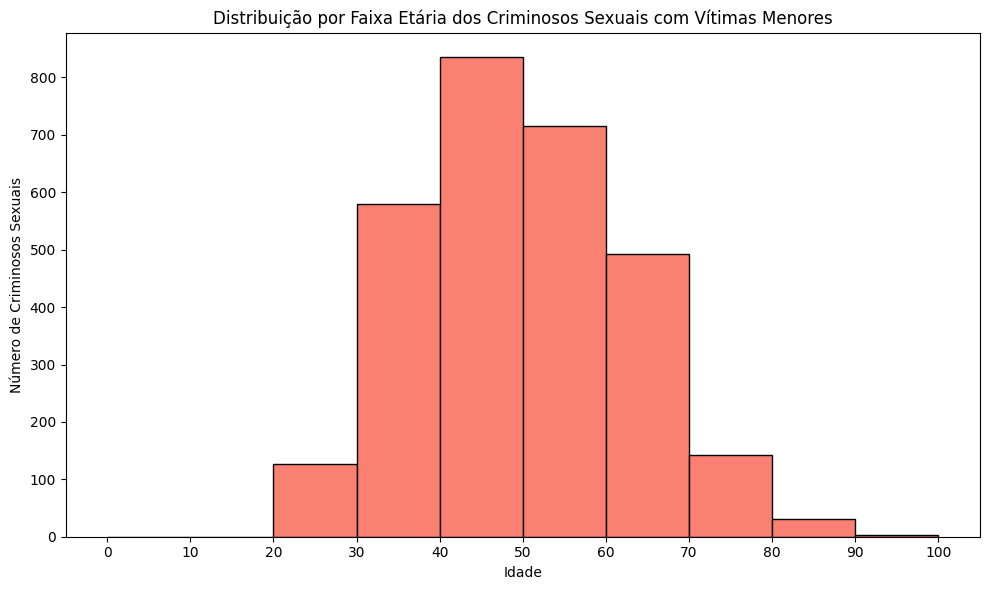

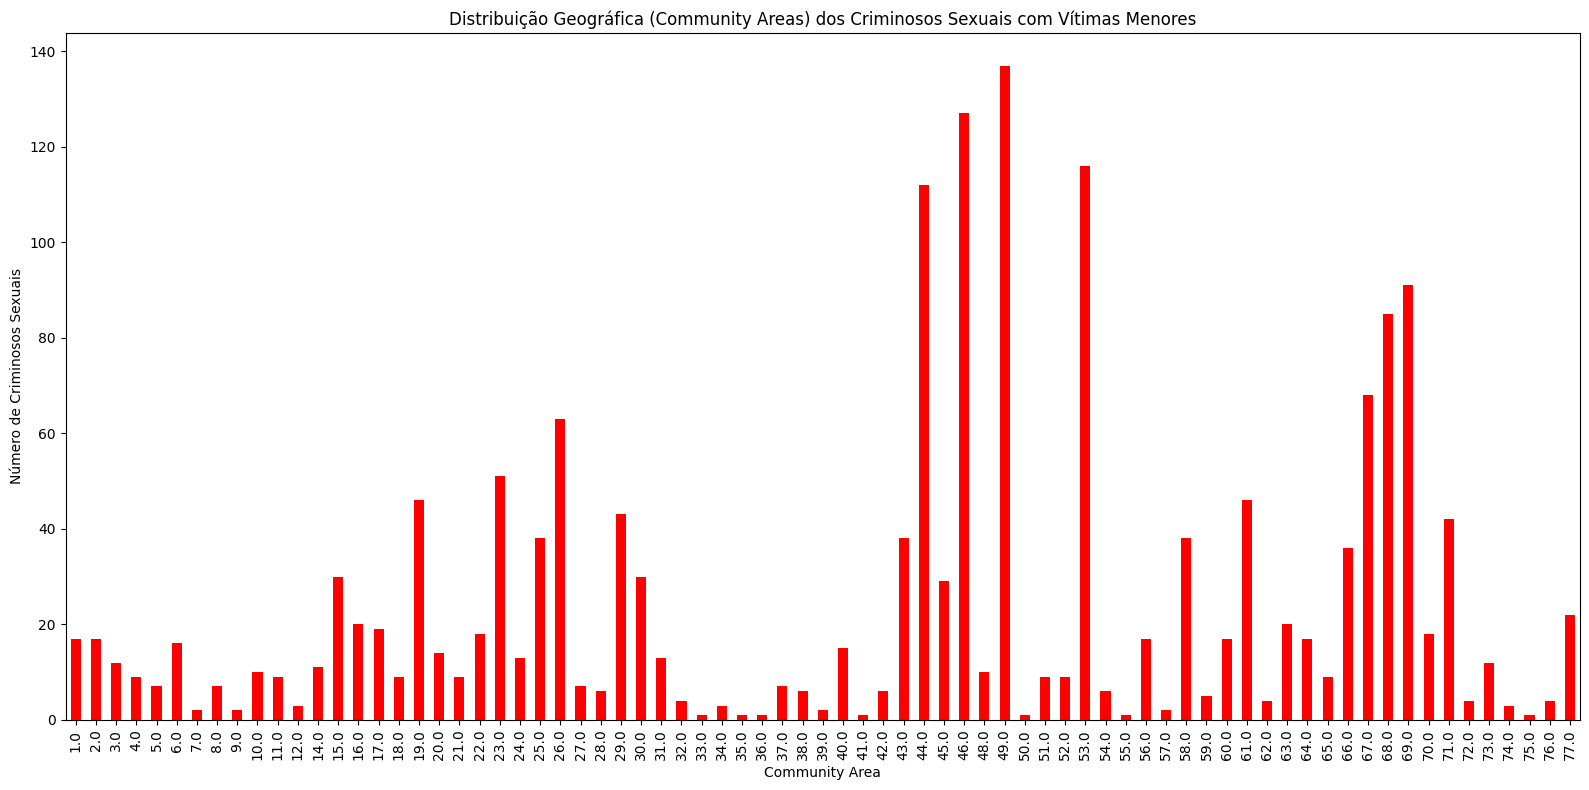

In [56]:
import matplotlib.pyplot as plt
# Cálculo da idade dos criminosos registrados
data_atual = pd.to_datetime("today")
sex_offenders['IDADE'] = (data_atual - sex_offenders['BIRTH DATE']).dt.days // 365
print()
# Separação de criminosos onde 'VICTIM MINOR'== Y
criminosos_vitima_menor = sex_offenders[sex_offenders['VICTIM MINOR'] == 'Y']
#Histograma
plt.figure(figsize=(10,6))
plt.hist(criminosos_vitima_menor['IDADE'], bins=range(0, 101, 10), color='salmon', edgecolor='black')
plt.title('Distribuição por Faixa Etária dos Criminosos Sexuais com Vítimas Menores')
plt.xlabel('Idade')
plt.ylabel('Número de Criminosos Sexuais')
plt.xticks(range(0, 101, 10))
plt.tight_layout()
plt.show()
print()
# Distribuição geográfica desses criminosos
contagem_faixas_area = criminosos_vitima_menor['Community Area'].value_counts().sort_index()
plt.figure(figsize=(16, 8))
contagem_faixas_area.plot(kind='bar', color='red')
plt.title('Distribuição Geográfica (Community Areas) dos Criminosos Sexuais com Vítimas Menores')
plt.xlabel('Community Area')
plt.ylabel('Número de Criminosos Sexuais')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Quais são as "Community Areas" com maior número de criminosos sexuais? Quais tipos de crimes são mais comuns nessas áreas? Qual o perfil demográfico (raça, gênero) dos infratores que vivem nessas áreas?

In [57]:
criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
media_criminosos_por_area= criminosos_por_area.mean()
print('Média de criminosos por Community Area:', media_criminosos_por_area)
moda_criminosos_por_area= criminosos_por_area.mode()
print('Moda de criminosos por Community Area:', moda_criminosos_por_area)
mediana_criminosos_por_area= criminosos_por_area.median()
print('Mediana de criminosos por Community Area:', mediana_criminosos_por_area)
cv_criminosos_por_area = (criminosos_por_area.std() / criminosos_por_area.mean()) * 100
print(f'Coeficiente de Variação (CV): {cv_criminosos_por_area:.2f}%')

Média de criminosos por Community Area: 31.06578947368421
Moda de criminosos por Community Area: 0    3
Name: count, dtype: int64
Mediana de criminosos por Community Area: 16.0
Coeficiente de Variação (CV): 125.38%


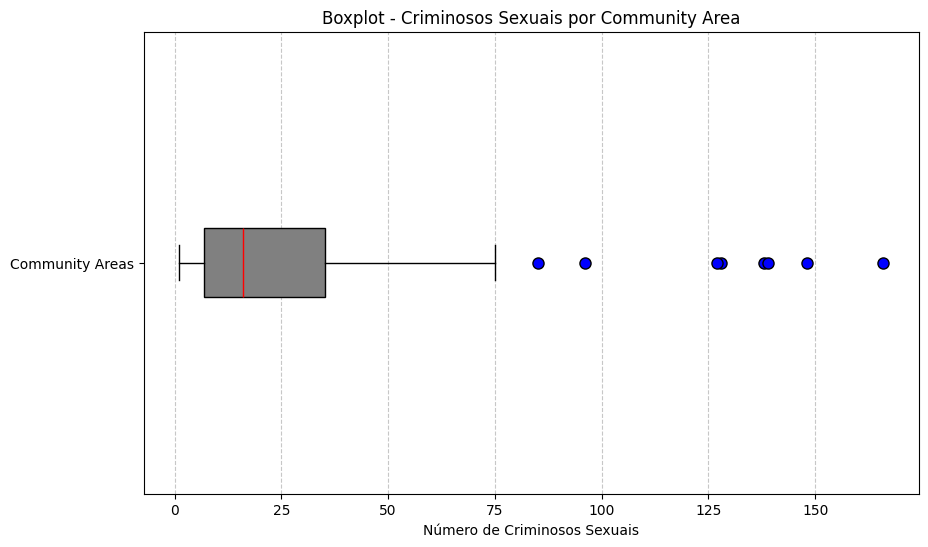

In [58]:
import matplotlib.pyplot as plt
# Boxplot da quantidade de criminosos sexuais por Community Area
plt.figure(figsize=(10, 6))
plt.boxplot(criminosos_por_area, vert=False, patch_artist=True,
            boxprops=dict(facecolor='grey', color='black'),
            medianprops=dict(color='red'),
            flierprops=dict(markerfacecolor='blue', marker='o', markersize=8, linestyle='none'))

plt.title('Boxplot - Criminosos Sexuais por Community Area')
plt.xlabel('Número de Criminosos Sexuais')
plt.yticks([1], ['Community Areas'])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


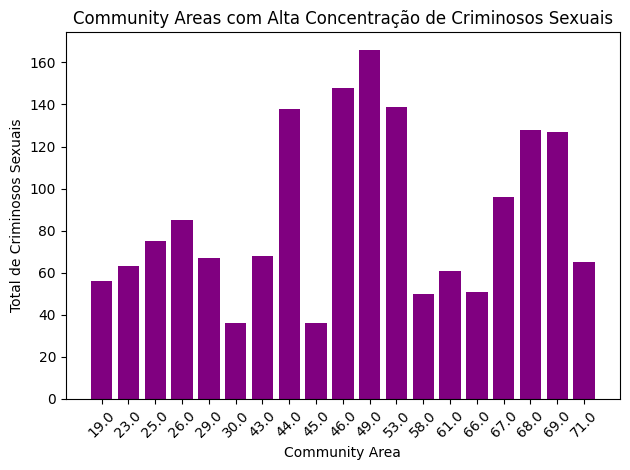

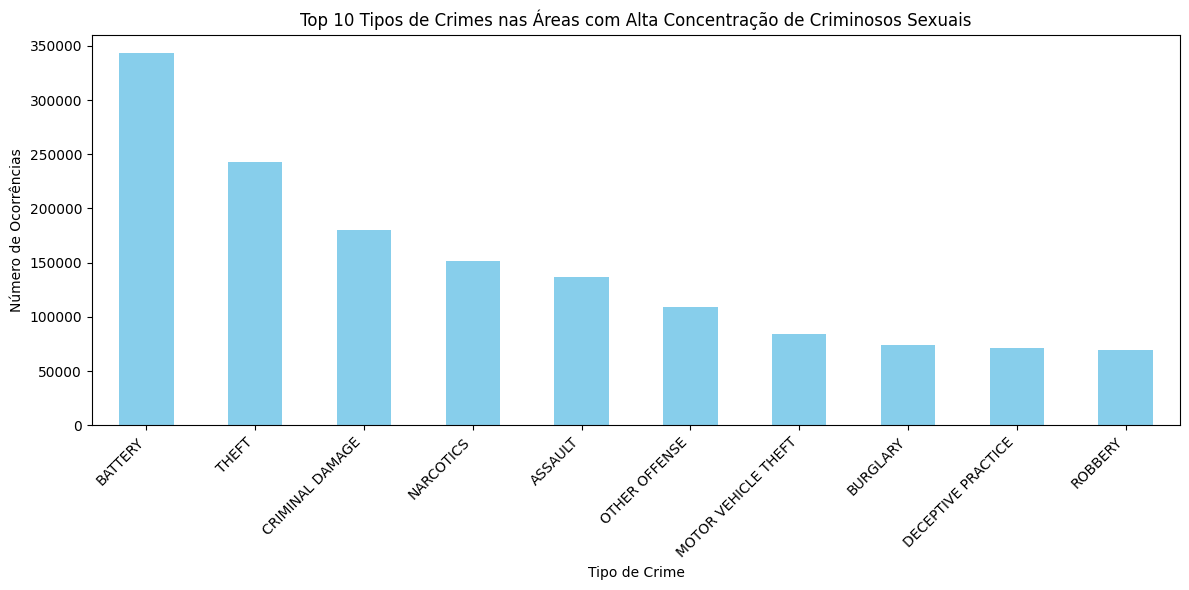


GENDER
MALE      1634
FEMALE      21
Name: count, dtype: int64
RACE
BLACK                           963
WHITE                           377
WHITE HISPANIC                  294
BLACK HISPANIC                   10
ASIAN / PACIFIC ISLANDER          7
UNKNOWN / REFUSED                 3
AMER INDIAN / ALASKAN NATIVE      1
Name: count, dtype: int64




RACE,AMER INDIAN / ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC,UNKNOWN / REFUSED
GENDER,,,,,,,
FEMALE,0.00,0.00,57.14,0.00,33.33,9.52,0.00
MALE,0.06,0.43,58.20,0.61,22.64,17.87,0.18


In [59]:
import matplotlib.pyplot as plt

criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
limiar_alta_concentracao = criminosos_por_area.quantile(0.75)
# Tabela com 'Community Areas' com n° de criminosos> limiar_alta_concentracao
areas_alta_concentracao = criminosos_por_area[criminosos_por_area > limiar_alta_concentracao]

# Gráfico de barras para áreas com alta concentração de criminosos sexuais
plt.bar(areas_alta_concentracao.index.astype(str),
        areas_alta_concentracao.values,
        color='purple')

plt.title('Community Areas com Alta Concentração de Criminosos Sexuais')
plt.xlabel('Community Area')
plt.ylabel('Total de Criminosos Sexuais')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print()
# Identificando crimes nessas áreas de alta concentração de criminosos sexuais
crimes_nas_areas = crimes[crimes['Community Area'].isin(areas_alta_concentracao.index)]
tipos_crimes_nas_areas = crimes_nas_areas['Primary Type'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
tipos_crimes_nas_areas.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Tipos de Crimes nas Áreas com Alta Concentração de Criminosos Sexuais')
plt.xlabel('Tipo de Crime')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print()
# Perfis demográficos dos criminosos sexuais nessas áreas de alta concentração
criminosos_nas_areas = criminosos_validos[criminosos_validos['Community Area'].isin(areas_alta_concentracao.index)]
# Quantidade dos perfis
genero_criminosos_nas_areas= criminosos_nas_areas['GENDER'].value_counts()
raça_criminosos_nas_areas= criminosos_nas_areas['RACE'].value_counts()
print(genero_criminosos_nas_areas)
print(raça_criminosos_nas_areas)
print()
# Tabela: Percentual de Criminosos por Gênero e Raça
#print("Categorias de Raça Disponíveis:", criminosos_nas_areas['RACE'].unique())
ordem_colunas = [
    'AMER INDIAN / ALASKAN NATIVE',
    'ASIAN / PACIFIC ISLANDER',
    'BLACK',
    'BLACK HISPANIC',
    'WHITE',
    'WHITE HISPANIC',
    'UNKNOWN / REFUSED'
]
tabela_genero_area = pd.crosstab(
    criminosos_nas_areas['GENDER'],
    criminosos_nas_areas['RACE'],
    normalize='index'
) * 100
for col in ordem_colunas:
    if col not in tabela_genero_area.columns:
        tabela_genero_area[col] = 0.0
tabela_genero_area = tabela_genero_area[ordem_colunas]
print()
display(
    tabela_genero_area.style
    .format("{:.2f}")
    .set_caption("Perfil Demográfico dos Criminosos Sexuais por Gênero e Raça (Por Percentual)")
)

#  Existem "Community Areas" em Chicago com alta frequência de crimes gerais e alta concentração de criminosos sexuais simultaneamente?

Quantidade de crimes gerais por Community Area: Community Area
1.0     55096
2.0     48625
3.0     53067
4.0     27233
5.0     19439
        ...  
73.0    43820
74.0     7917
75.0    28350
76.0    23824
77.0    37766
Name: count, Length: 77, dtype: int64
Quantidade de criminosos sexuais por Community Area: Community Area
1.0     21
2.0     21
3.0     19
4.0     15
5.0      9
        ..
73.0    22
74.0     3
75.0     5
76.0     5
77.0    28
Name: count, Length: 76, dtype: int64


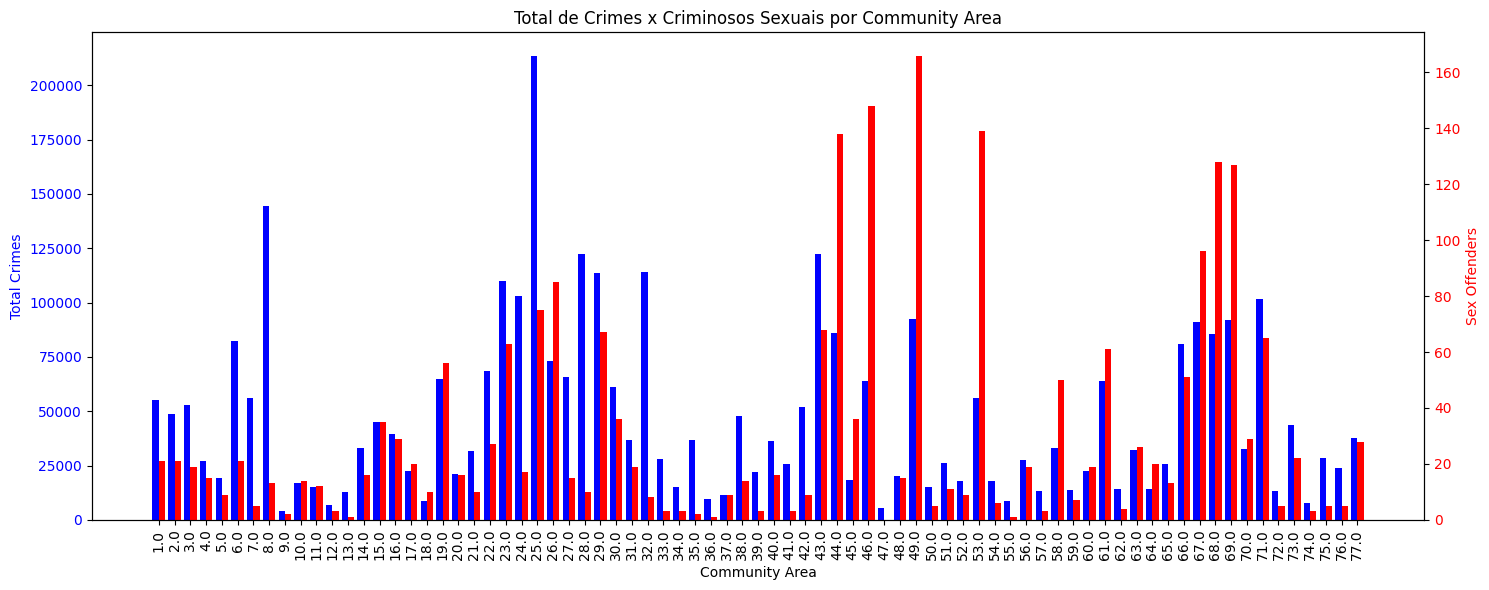

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Contagem de crimes totais por Community
crimes_validos = crimes.dropna(subset=['Community Area'])
# Eliminação de linhas sem community area
crimes_por_area = crimes_validos['Community Area'].value_counts().sort_index()
print('Quantidade de crimes gerais por Community Area:',crimes_por_area)

# Contagem de criminosos sexuais por community
criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
print('Quantidade de criminosos sexuais por Community Area:', criminosos_por_area)

# Gráfico Comparativo com 2 eixo y por causa da discrepância entre os dados comparados
df_comparativo = pd.DataFrame({
    'Total Crimes': crimes_por_area,
    'Sex Offenders': criminosos_por_area
})
x = np.arange(len(df_comparativo.index))
width = 0.4
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.bar(x - width/2, df_comparativo['Total Crimes'], width, color='blue', label='Total Crimes')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparativo.index.astype(str), rotation=90)
ax1.set_xlabel('Community Area')
ax1.set_ylabel('Total Crimes', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(df_comparativo.index.astype(str), rotation=90)
ax2 = ax1.twinx()
ax2.bar(df_comparativo.index.astype(str), df_comparativo['Sex Offenders'], color='red', width=0.4, label='Sex Offenders', align='edge')
ax2.set_ylabel('Sex Offenders', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Total de Crimes x Criminosos Sexuais por Community Area')
plt.tight_layout()
plt.show()


# Os principais tipos de crimes são diferentes entre as “Community Areas” com alta e com baixa concentração de criminosos sexuais?

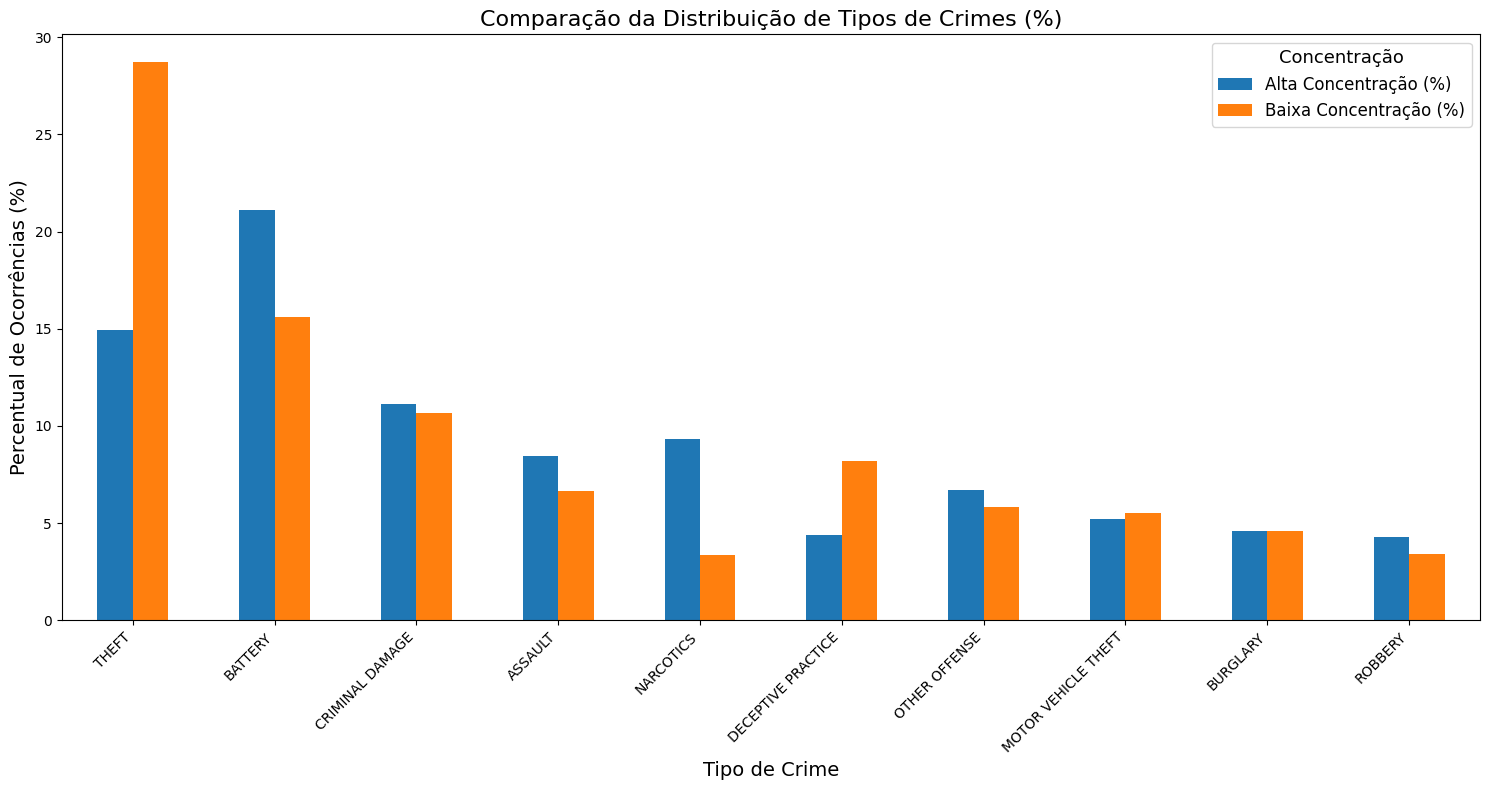


Community Area         Alta   Baixa
Primary Type                       
ASSAULT              136826  133310
BATTERY              343023  312367
BURGLARY              74181   92371
CRIMINAL DAMAGE      180296  213063
DECEPTIVE PRACTICE    71194  163625
MOTOR VEHICLE THEFT   84172  110925
NARCOTICS            151380   66802
OTHER OFFENSE        108817  116121
ROBBERY               69391   68213
THEFT                242528  574297


In [61]:
import matplotlib.pyplot as plt

#Separação das áreas por alta ou baixa concentração de criminosos sexuais registrados
criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
limiar_alta_concentracao = criminosos_por_area.quantile(0.75)
areas_alta_concentracao = criminosos_por_area[criminosos_por_area > limiar_alta_concentracao].index
areas_baixa_concentracao = criminosos_por_area[criminosos_por_area <= limiar_alta_concentracao].index
#Cálculo da quantidade de crimes por área de alta ou baixa concentração de criminosos sexuais registrados
crimes['Concentracao'] = crimes['Community Area'].isin(areas_alta_concentracao).map({True: 'Alta', False: 'Baixa'})
# Distribuição percentual por tipo de crime
crimes_alta = crimes[crimes['Concentracao'] == 'Alta']
crimes_baixa = crimes[crimes['Concentracao'] == 'Baixa']

distribuicao_alta = crimes_alta['Primary Type'].value_counts(normalize=True) * 100
distribuicao_baixa = crimes_baixa['Primary Type'].value_counts(normalize=True) * 100
#Construção do gráfico comparativo
df_comparacao = pd.DataFrame({
    'Alta Concentração (%)': distribuicao_alta,
    'Baixa Concentração (%)': distribuicao_baixa
}).fillna(0).sort_values(by='Alta Concentração (%)', ascending=False)

top_crimes = df_comparacao.sum(axis=1).sort_values(ascending=False).head(10).index
df_top = df_comparacao.loc[top_crimes]

ax = df_top.plot(kind='bar', figsize=(15, 8))
plt.title("Comparação da Distribuição de Tipos de Crimes (%)", fontsize=16)
plt.xlabel("Tipo de Crime", fontsize=14)
plt.ylabel("Percentual de Ocorrências (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Concentração', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()
print()
tabela_top = pd.crosstab(
    crimes[crimes['Primary Type'].isin(top_crimes)]['Primary Type'],
    crimes['Community Area'].isin(areas_alta_concentracao).map({True: 'Alta', False: 'Baixa'})
)
print(tabela_top)

# Quais são os três tipos de crimes gerais mais comuns nas “Community Areas” com maior incidência de crimes sexuais, e como eles se comparam com as áreas de baixa incidência de crimes sexuais? Há diferença estatisticamente significativa na distribuição desses crimes entre as duas categorias de áreas?

Áreas com alta incidência: [25.0, 8.0, 28.0, 43.0, 29.0]
Áreas com baixa incidência: [37.0, 18.0, 12.0, 47.0, 9.0]

Top 3 crimes em áreas de alta incidência:
 Primary Type
THEFT              168879
BATTERY            132562
CRIMINAL DAMAGE     66988
Name: count, dtype: int64

Top 3 crimes em áreas de baixa incidência:
 Primary Type
THEFT              7408
BATTERY            5872
CRIMINAL DAMAGE    4357
Name: count, dtype: int64


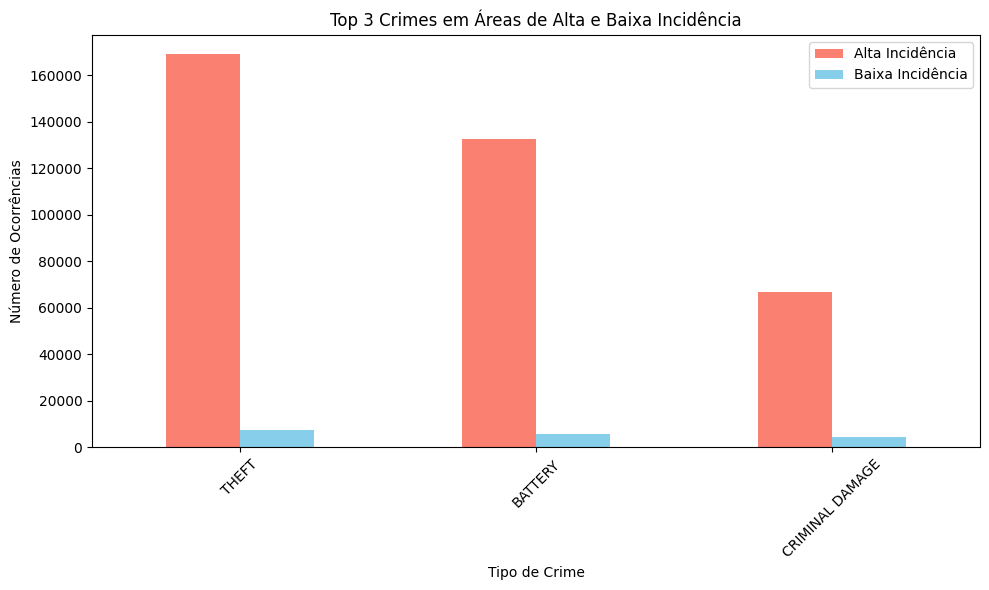



Tabela de Contingência:
 Primary Type       THEFT  BATTERY  CRIMINAL DAMAGE
Alta Incidência   168879   132562            66988
Baixa Incidência    7408     5872             4357


Resultado do Teste Qui-Quadrado:
Estatística Qui-Quadrado: 475.470570687796
p-valor: 5.660794919431076e-104
Graus de Liberdade: 2
Frequências esperadas:
[[168233.52256609 132109.7951801   68085.68225381]
 [  8053.47743391   6324.2048199    3259.31774619]]
Resultado: Hipótese nula (H₀) rejeitada. Existe associação entre o tipo de crime e a categoria da área.



In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

crimes_validos = crimes.dropna(subset=['Community Area'])
tipos_sexuais = ['SEX OFFENSE','CRIMINAL SEXUAL ASSAULT','CRIM SEXUAL ASSAULT']
crimes_sexuais = crimes_validos[crimes_validos['Primary Type'].isin(tipos_sexuais)]
contagem_crimes_sexuais = crimes_sexuais['Community Area'].value_counts()

areas_alta = contagem_crimes_sexuais.head(5).index
areas_baixa = contagem_crimes_sexuais.tail(5).index
print("Áreas com alta incidência:", areas_alta.tolist())
print("Áreas com baixa incidência:", areas_baixa.tolist())

#Identificação dos tipos criminais gerais que mais aparecem em cada categoria
crimes_alta = crimes_validos[crimes_validos['Community Area'].isin(areas_alta)]
crimes_baixa = crimes_validos[crimes_validos['Community Area'].isin(areas_baixa)]
top3_alta = crimes_alta['Primary Type'].value_counts().head(3)
top3_baixa = crimes_baixa['Primary Type'].value_counts().head(3)
print("\nTop 3 crimes em áreas de alta incidência:\n", top3_alta)
print("\nTop 3 crimes em áreas de baixa incidência:\n", top3_baixa)

#Gráfico de barras - visualizar distribuição nos dois tipos
df_plot = pd.DataFrame({
    'Alta Incidência': top3_alta,
    'Baixa Incidência': top3_baixa
}).fillna(0)

df_plot.plot(kind='bar', figsize=(10,6), color=['salmon', 'skyblue'])
plt.title('Top 3 Crimes em Áreas de Alta e Baixa Incidência')
plt.xlabel('Tipo de Crime')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print()
#Tabela de contingência
tabela_contingencia = df_plot.T.astype(int)
print("\nTabela de Contingência:\n", tabela_contingencia)
print ()
#Teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(tabela_contingencia)
print(f"\nResultado do Teste Qui-Quadrado:")
print(f"Estatística Qui-Quadrado: {chi2}")
print(f"p-valor: {p}")
print(f"Graus de Liberdade: {dof}")
print(f"Frequências esperadas:\n{expected}")

alpha = 0.05
if p_value < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada. Existe associação entre o tipo de crime e a categoria da área.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada.Não há associação entre o tipo de crime e a categoria da área (alta ou baixa incidência de crimes sexuais).\n")

# Qual a probabilidade de um crime ocorrer em uma “Community Area” que possui um número de criminosos sexuais maior que a mediana?


In [63]:
# Separação das "Community Areas" comparando com a mediana
criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
mediana_criminosos_por_area= criminosos_por_area.median()
print('Mediana de criminosos por Community Area:', mediana_criminosos_por_area)
# Seleção das areas com número de criminosos > mediana
areas_com_mais_criminosos = criminosos_por_area[criminosos_por_area > mediana_criminosos_por_area].index
quantidade_crimes_areas_mais_criminosos = crimes[crimes['Community Area'].isin(areas_com_mais_criminosos)]
print("Community Areas com mais criminosos sexuais registrados que a mediana:", list(areas_com_mais_criminosos))
print("Número de crimes nessas áreas:", len(quantidade_crimes_areas_mais_criminosos))
# Seleção das areas com número de criminosos <= mediana
areas_com_menos_igual_criminosos = criminosos_por_area[criminosos_por_area <= mediana_criminosos_por_area].index
quantidade_crimes_areas_menos_igual_criminosos = crimes[crimes['Community Area'].isin(areas_com_menos_igual_criminosos)]
print("Community Areas com criminosos sexuais registrados menor ou igual à mediana:", list(areas_com_menos_igual_criminosos))
print("Número de crimes nessas áreas:", len(quantidade_crimes_areas_menos_igual_criminosos))
# Contagem do total de crimes na cidade
total_crimes = len(crimes)
print("Número total de crimes na cidade:", total_crimes)
# Cálculo da probabilidade para áreas com mais criminosos que a mediana
probabilidade_mais_criminosos = len(quantidade_crimes_areas_mais_criminosos) / total_crimes
print(f"Probabilidade de ocorrer um crime em 'Community Area' com criminosos sexuais > mediana: {probabilidade_mais_criminosos:.4f}")
# Cálculo da probabilidade para áreas com criminosos <= mediana
probabilidade_menos_igual_criminosos = len(quantidade_crimes_areas_menos_igual_criminosos) / total_crimes
print(f"Probabilidade de ocorrer um crime em 'Community Area' com criminosos sexuais <= mediana: {probabilidade_menos_igual_criminosos:.4f}")
# Comparação
if probabilidade_mais_criminosos > probabilidade_menos_igual_criminosos:
    print("Há maior probabilidade de ocorrência de crimes nas áreas com mais criminosos sexuais que a mediana.")
elif probabilidade_mais_criminosos < probabilidade_menos_igual_criminosos:
    print("Há maior probabilidade de ocorrência de crimes nas áreas com criminosos sexuais menores ou iguais à mediana.")
else:
    print("A probabilidade de ocorrência de crimes é igual em ambas as categorias.")

Mediana de criminosos por Community Area: 16.0
Community Areas com mais criminosos sexuais registrados que a mediana: [1.0, 2.0, 3.0, 6.0, 15.0, 16.0, 17.0, 19.0, 22.0, 23.0, 24.0, 25.0, 26.0, 29.0, 30.0, 31.0, 43.0, 44.0, 45.0, 46.0, 49.0, 53.0, 56.0, 58.0, 60.0, 61.0, 63.0, 64.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 73.0, 77.0]
Número de crimes nessas áreas: 2387955
Community Areas com criminosos sexuais registrados menor ou igual à mediana: [4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 18.0, 20.0, 21.0, 27.0, 28.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 48.0, 50.0, 51.0, 52.0, 54.0, 55.0, 57.0, 59.0, 62.0, 65.0, 72.0, 74.0, 75.0, 76.0]
Número de crimes nessas áreas: 1229751
Número total de crimes na cidade: 3622935
Probabilidade de ocorrer um crime em 'Community Area' com criminosos sexuais > mediana: 0.6591
Probabilidade de ocorrer um crime em 'Community Area' com criminosos sexuais <= mediana: 0.3394
Há maior probabilidade de ocorrência de crime

# Há relação entre a tendência no número de crimes sexuais ocorridos com o número de crimes gerais ao longo dos anos?

      Crimes Não Sexuais  Crimes Sexuais
Year                                    
2011               85338             603
2012              333769            2557
2013              305160            2416
2014              273443            2419
2015              262359            2512
2016              267263            2684
2017              266490            2768
2018              266091            3007
2019              258564            3050
2020              210349            2239
2021              206828            2640
2022              236963            2832
2023              259972            3022
2024              255506            2826
2025               98023            1242
Correlação entre crimes não sexuais e crimes sexuais ao longo dos anos (r): 0.82


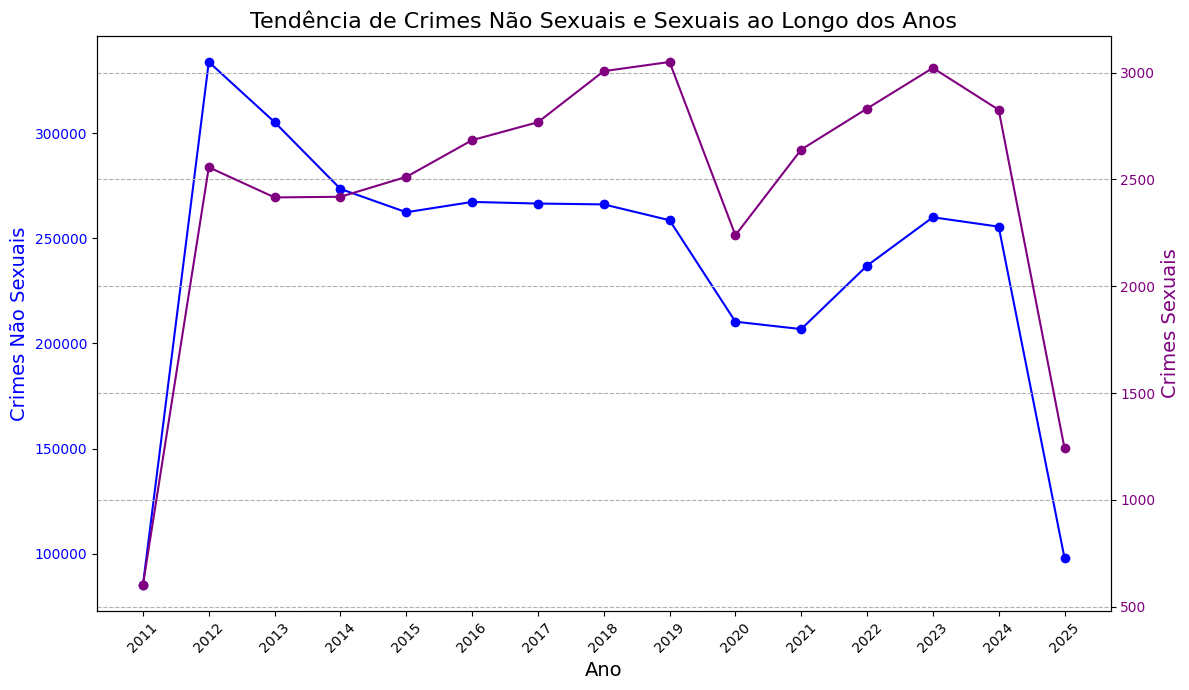

In [64]:
import matplotlib.pyplot as plt
#Contagem do número de crimes sexuais
crimes_validos = crimes.dropna(subset=['Community Area'])
tipos_sexuais = ['SEX OFFENSE','CRIMINAL SEXUAL ASSAULT','CRIM SEXUAL ASSAULT']
crimes_sexuais = crimes_validos[crimes_validos['Primary Type'].isin(tipos_sexuais)]
#Contagem do número de crimes não sexuais
crimes_nao_sexuais = crimes_validos[~crimes_validos['Primary Type'].isin(tipos_sexuais)]
#Separação por ano
crimes_sexuais_por_ano = crimes_sexuais['Year'].value_counts().sort_index()
crimes_nao_sexuais_por_ano = crimes_nao_sexuais['Year'].value_counts().sort_index()

df_tendencia = pd.DataFrame({
    'Crimes Não Sexuais': crimes_nao_sexuais_por_ano,
    'Crimes Sexuais': crimes_sexuais_por_ano
}).fillna(0).astype(int)

print(df_tendencia)

#Correlação:
correlacao = df_tendencia['Crimes Não Sexuais'].corr(df_tendencia['Crimes Sexuais'])
print(f"Correlação entre crimes não sexuais e crimes sexuais ao longo dos anos (r): {correlacao:.2f}")

fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(df_tendencia.index, df_tendencia['Crimes Não Sexuais'], marker='o', color='blue', label='Crimes Não Sexuais')
ax1.set_xlabel('Ano', fontsize=14)
ax1.set_ylabel('Crimes Não Sexuais', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(df_tendencia.index, df_tendencia['Crimes Sexuais'], marker='o', color='purple', label='Crimes Sexuais')
ax2.set_ylabel('Crimes Sexuais', color='purple', fontsize=14)
ax2.tick_params(axis='y', labelcolor='purple')
ax1.set_xticks(df_tendencia.index)
ax1.set_xticklabels(df_tendencia.index, rotation=45)
plt.title('Tendência de Crimes Não Sexuais e Sexuais ao Longo dos Anos', fontsize=16)
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

# Qual a variação dos crimes sexuais em relação ao total de crimes anualmente em Chicago?

      Total de Crimes  Crimes Sexuais  Proporção (%)
Year                                                
2011            85941             603           0.70
2012           336326            2557           0.76
2013           307576            2416           0.79
2014           275862            2419           0.88
2015           264871            2512           0.95
2016           269947            2684           0.99
2017           269258            2768           1.03
2018           269098            3007           1.12
2019           261614            3050           1.17
2020           212588            2239           1.05
2021           209468            2640           1.26
2022           239795            2832           1.18
2023           262994            3022           1.15
2024           258332            2826           1.09
2025            99265            1242           1.25



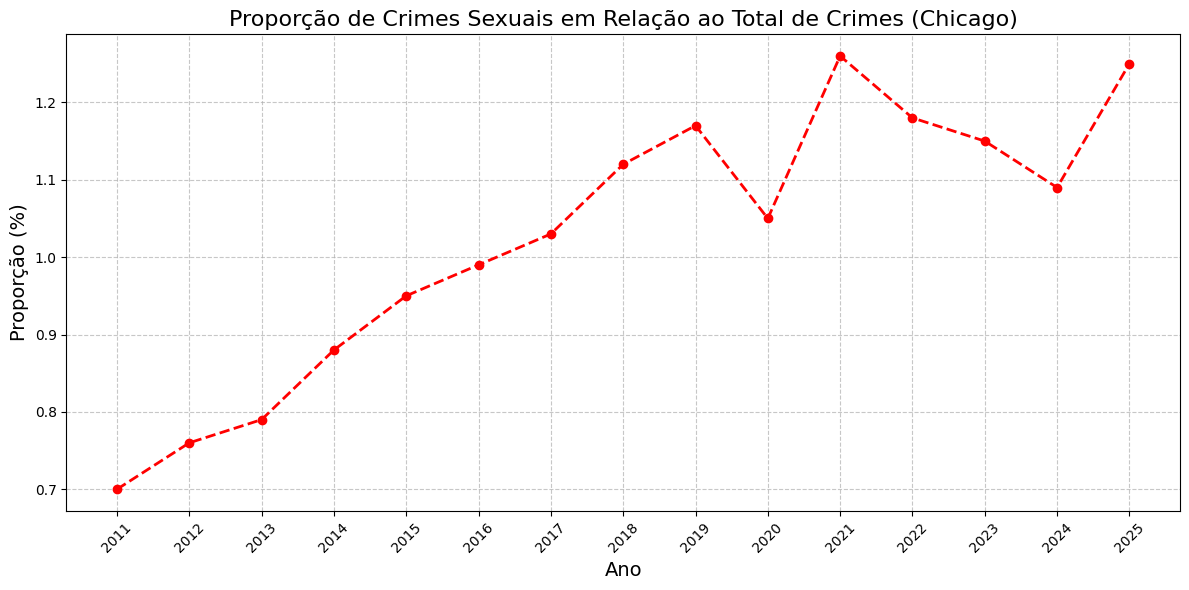




Teste Qui-Quadrado:
Qui²: 926.8738033743251
p-valor: 7.519155739225498e-189
Graus de liberdade: 14
Frequências esperadas:
[[   873.34986606  85067.65013394]
 [  3417.81300023 332908.18699977]
 [  3125.64967133 304450.35032867]
 [  2803.36557349 273058.63442651]
 [  2691.67280313 262179.32719687]
 [  2743.25614426 267203.74385574]
 [  2736.25438657 266521.74561343]
 [  2734.62843413 266363.37156587]
 [  2658.57450879 258955.42549121]
 [  2160.36235704 210427.63764296]
 [  2128.65628448 207339.34371552]
 [  2436.84540711 237358.15459289]
 [  2672.59834858 260321.40165142]
 [  2625.22215938 255706.77784062]
 [  1008.75105543  98256.24894457]]
Resultado: Rejeita-se a hipótese nula (H₀). Há diferença significativa nas proporções de crimes sexuais entre os anos.


In [42]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#Filtragem dos tipos de crimes (sexuais e nao sexuais)
tipos_sexuais = ['SEX OFFENSE', 'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT']
crimes_validos = crimes.dropna(subset=['Community Area'])
crimes_sexuais = crimes_validos[crimes_validos['Primary Type'].isin(tipos_sexuais)]

total_por_ano = crimes_validos['Year'].value_counts().sort_index()
sexuais_por_ano = crimes_sexuais['Year'].value_counts().sort_index()

proporcao_sexual = (sexuais_por_ano / total_por_ano) * 100

df_proporcao = pd.DataFrame({
    'Total de Crimes': total_por_ano,
    'Crimes Sexuais': sexuais_por_ano,
    'Proporção (%)': proporcao_sexual.round(2)
})
print(df_proporcao)
print()
# Gráfico da proporção ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(df_proporcao.index, df_proporcao['Proporção (%)'],
         marker='o',
         color='red',
         linestyle='--',
         linewidth=2)

plt.title('Proporção de Crimes Sexuais em Relação ao Total de Crimes (Chicago)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Proporção (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(df_proporcao.index, rotation=45)
plt.tight_layout()
plt.show()
print("\n")
tabela = []
for ano in df_proporcao.index:
    sexuais = df_proporcao.loc[ano, 'Crimes Sexuais']
    nao_sexuais = df_proporcao.loc[ano, 'Total de Crimes'] - sexuais
    tabela.append([sexuais, nao_sexuais])

chi2, p, dof, expected = chi2_contingency(tabela)
print("\nTeste Qui-Quadrado:")
print(f"Qui²: {chi2}")
print(f"p-valor: {p}")
print(f"Graus de liberdade: {dof}")
print(f"Frequências esperadas:\n{expected}")

alpha = 0.05
if p < alpha:
    print("Resultado: Rejeita-se a hipótese nula (H₀). Há diferença significativa nas proporções de crimes sexuais entre os anos.")
else:
    print("Resultado: Não se rejeita a hipótese nula (H₀). Não há diferença significativa nas proporções de crimes sexuais entre os anos.")

# Existe alguma relação entre a taxa de prisão para crimes sexuais e para crimes gerais?


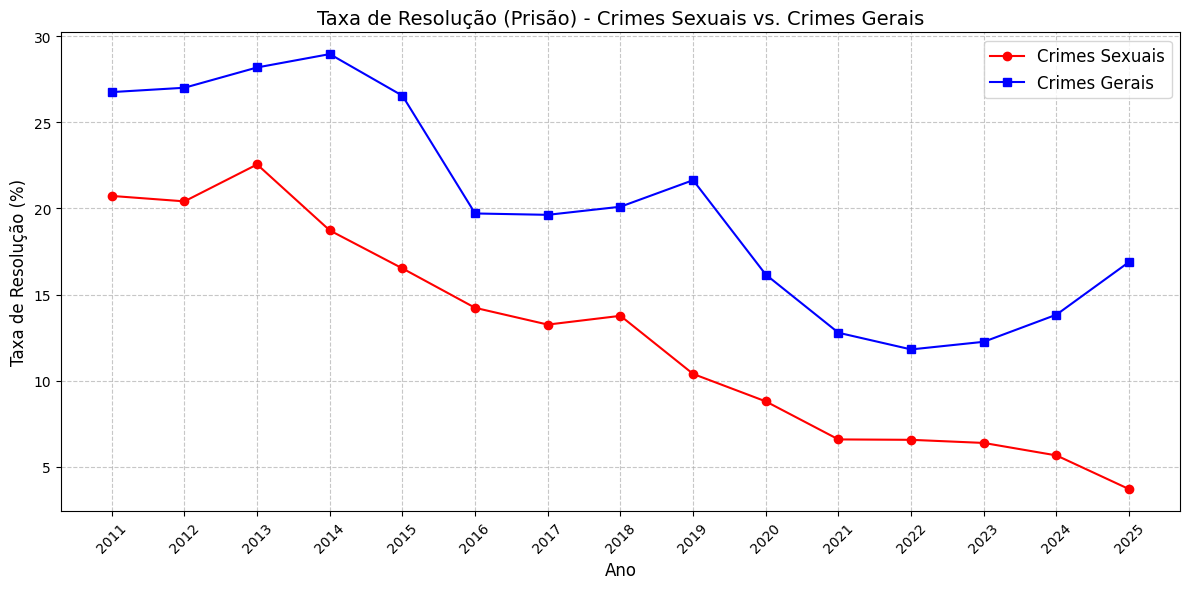

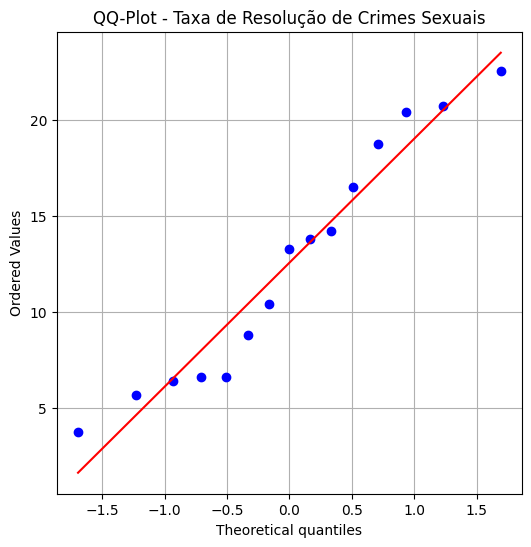

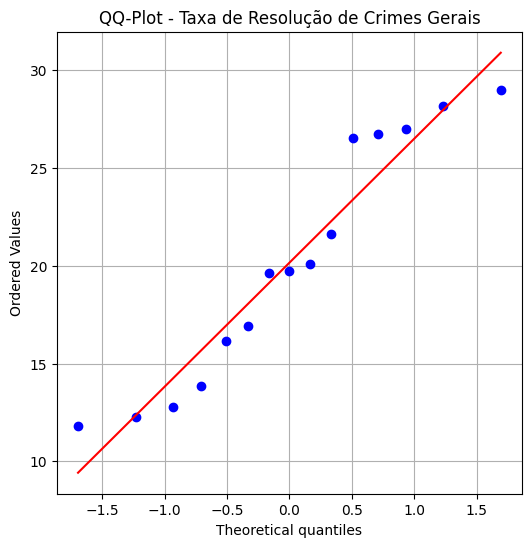


Normalidade - Taxa de Resolução de Crimes Sexuais:
ShapiroResult(statistic=np.float64(0.9304573386292063), pvalue=np.float64(0.2772026362229164))
Resultado: Não se rejeita a hipótese nula (H₀). A distribuição pode ser considerada normal.


Normalidade - Taxa de Resolução de Crimes Gerais:
ShapiroResult(statistic=np.float64(0.9081135358327677), pvalue=np.float64(0.12668456361821367))
Resultado: Não se rejeita a hipótese nula (H₀). A distribuição pode ser considerada normal.


Teste t pareado:
Estatística t: -12.067836533408418
p-valor: 8.700141447429958e-09
Resultado: Hipótese nula (H₀) rejeitada.Há diferença significativa nas taxas médias de resolução entre crimes sexuais e crimes gerais.



In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
from scipy.stats import ttest_rel
#Filtragem dos crimes em categorias (sexuais ou não sexuais)
tipos_sexuais = ['SEX OFFENSE', 'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT']
crimes_sexuais = crimes_validos[crimes_validos['Primary Type'].isin(tipos_sexuais)]
crimes_gerais = crimes_validos[~crimes_validos['Primary Type'].isin(tipos_sexuais)]
# Contagem dos crimes reportados por ano
reportados_sexuais = crimes_sexuais['Year'].value_counts().sort_index()
reportados_gerais = crimes_gerais['Year'].value_counts().sort_index()
# Contagem dos crimes resolvidos ('Arrest' == true) por ano
resolvidos_sexuais = crimes_sexuais[crimes_sexuais['Arrest'] == True]['Year'].value_counts().sort_index()
resolvidos_gerais = crimes_gerais[crimes_gerais['Arrest'] == True]['Year'].value_counts().sort_index()
#Armazenamento das taxa em 'series'
anos = sorted(crimes_validos['Year'].unique())
taxa_sexuais = pd.Series(index=anos, dtype=float)
taxa_gerais = pd.Series(index=anos, dtype=float)
# Calculo da taxa para cada ano
for ano in anos:
    total_sex = reportados_sexuais.get(ano, 0)
    resolvidos_sex = resolvidos_sexuais.get(ano, 0)
    taxa_sexuais[ano] = (resolvidos_sex / total_sex) * 100 if total_sex != 0 else 0
    total_geral = reportados_gerais.get(ano, 0)
    resolvidos_geral = resolvidos_gerais.get(ano, 0)
    taxa_gerais[ano] = (resolvidos_geral / total_geral) * 100 if total_geral != 0 else 0
# Gráfico de linhas para visualização Comparativa
plt.figure(figsize=(12, 6))
plt.plot(taxa_sexuais.index, taxa_sexuais.values, label='Crimes Sexuais', marker='o', color='red')
plt.plot(taxa_gerais.index, taxa_gerais.values, label='Crimes Gerais', marker='s', color='blue')
plt.title('Taxa de Resolução (Prisão) - Crimes Sexuais vs. Crimes Gerais', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Resolução (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(anos, rotation=45)
plt.tight_layout()
plt.show()
print()
# QQ-Plot para Taxa de Resolução de Crimes Sexuais
plt.figure(figsize=(6,6))
probplot(taxa_sexuais.values, dist="norm", plot=plt)
plt.title('QQ-Plot - Taxa de Resolução de Crimes Sexuais')
plt.grid(True)
plt.show()
print()
# QQ-Plot para Taxa de Resolução de Crimes Gerais
plt.figure(figsize=(6,6))
probplot(taxa_gerais.values, dist="norm", plot=plt)
plt.title('QQ-Plot - Taxa de Resolução de Crimes Gerais')
plt.grid(True)
plt.show()
print()
#Teste de shapiro - normalidade
alpha = 0.05

print("Normalidade - Taxa de Resolução de Crimes Sexuais:")
resultado_sexuais = shapiro(taxa_sexuais.values)
print(resultado_sexuais)

if resultado_sexuais.pvalue < alpha:
    print("Resultado: Rejeita-se a hipótese nula (H₀). A distribuição NÃO é normal.\n")
else:
    print("Resultado: Não se rejeita a hipótese nula (H₀). A distribuição pode ser considerada normal.\n")
print()
print("Normalidade - Taxa de Resolução de Crimes Gerais:")
resultado_gerais = shapiro(taxa_gerais.values)
print(resultado_gerais)

if resultado_gerais.pvalue < alpha:
    print("Resultado: Rejeita-se a hipótese nula (H₀). A distribuição NÃO é normal.\n")
else:
    print("Resultado: Não se rejeita a hipótese nula (H₀). A distribuição pode ser considerada normal.\n")

print()
#Teste t pareado
stat, p = ttest_rel(taxa_sexuais.values, taxa_gerais.values)
print(f"Teste t pareado:")
print(f"Estatística t: {stat}")
print(f"p-valor: {p}")

alpha = 0.05
if p < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada.Há diferença significativa nas taxas médias de resolução entre crimes sexuais e crimes gerais.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada.Não há diferença significativa nas taxas médias de resolução entre crimes sexuais e crimes gerais.\n")

# A média anual de crimes é diferente entre as “Community Areas” com uma proporção maior de criminosos sexuais e aqueles com uma proporção menor?



In [66]:
from scipy.stats import shapiro, mannwhitneyu

#Cálculo de crimes em áreas com uma concentração 'BAIXA' de criminosos sexuais
criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
limiar_alta_concentracao = criminosos_por_area.quantile(0.75)
areas_baixa_concentracao = criminosos_por_area[criminosos_por_area <= limiar_alta_concentracao].index
crimes_nas_areas_baixa = crimes[crimes['Community Area'].isin(areas_baixa_concentracao)]
media_anual_crimes_baixa = crimes_nas_areas_baixa.groupby('Year').size().mean()
print(f"Média anual de crimes gerais nas Community Areas com baixa concentração de criminosos sexuais: {media_anual_crimes_baixa:.2f}")
#Cálculo de crimes em áreas com uma concentração 'ALTA' de criminosos sexuais
areas_alta_concentracao = criminosos_por_area[criminosos_por_area > limiar_alta_concentracao].index
crimes_nas_areas_alta = crimes[crimes['Community Area'].isin(areas_alta_concentracao)]
media_anual_crimes_alta = crimes_nas_areas_alta.groupby('Year').size().mean()
print(f"Média anual de crimes gerais nas Community Areas com alta concentração de criminosos sexuais: {media_anual_crimes_alta:.2f}")
#Teste de shapiro - normalidade
alpha = 0.05
print("Normalidade - Áreas com baixa concentração:")
crimes_nas_areas_baixa_norm= shapiro(crimes_nas_areas_baixa.groupby('Year').size())
print(crimes_nas_areas_baixa_norm)
if crimes_nas_areas_baixa_norm.pvalue < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada. A distribuição NÃO é normal.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada. A distribuição é normal.\n")

print("Normalidade - Áreas com alta concentração:")
crimes_nas_areas_alta_norm= shapiro(crimes_nas_areas_alta.groupby('Year').size())
print(crimes_nas_areas_alta_norm)
if crimes_nas_areas_alta_norm.pvalue < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada A distribuição NÃO é normal.\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada. A distribuição é normal.\n")
print()
# Teste Mann-Whitney U
media_anual_baixa = crimes_nas_areas_baixa.groupby('Year').size()
media_anual_alta = crimes_nas_areas_alta.groupby('Year').size()
stat, p = mannwhitneyu(media_anual_baixa, media_anual_alta, alternative='two-sided')
print(f'Teste de Mann-Whitney U:\nEstatística U = {stat}, p-valor = {p}')

alpha = 0.05
if p < alpha:
    print("Resultado: Hipótese nula (H₀) rejeitada.A distribuição da média anual de crimes nas “Community Areas” com alta concentração é diferente da das “Community Areas” com baixa concentração..\n")
else:
    print("Resultado: Hipótese nula (H₀) não pode ser rejeitada.A distribuição da média anual de crimes nas “Community Areas” com alta concentração de criminosos sexuais é igual à das “Community Areas” com baixa concentração..\n")

Média anual de crimes gerais nas Community Areas com baixa concentração de criminosos sexuais: 132986.93
Média anual de crimes gerais nas Community Areas com alta concentração de criminosos sexuais: 108193.47
Normalidade - Áreas com baixa concentração:
ShapiroResult(statistic=np.float64(0.7959629831829911), pvalue=np.float64(0.0032644538889512018))
Resultado: Hipótese nula (H₀) rejeitada. A distribuição NÃO é normal.

Normalidade - Áreas com alta concentração:
ShapiroResult(statistic=np.float64(0.891362919797989), pvalue=np.float64(0.07032169455696578))
Resultado: Hipótese nula (H₀) não pode ser rejeitada. A distribuição é normal.


Teste de Mann-Whitney U:
Estatística U = 170.0, p-valor = 0.01806662299891238
Resultado: Hipótese nula (H₀) rejeitada.A distribuição da média anual de crimes nas “Community Areas” com alta concentração é diferente da das “Community Areas” com baixa concentração..



# A probabilidade de um crime sexual ocorrer em uma “Community Area” na qual existe mais de um criminoso sexual registrado é maior que nas “Community Areas” com um ou nenhum criminoso sexual registrado?


In [70]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np


criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
#Separação das áreas com mais ou menos de 1 criminoso sexual registrado
areas_mais_de_um_criminoso = criminosos_por_area[criminosos_por_area > 1].index
areas_um_ou_menos_criminosos = criminosos_por_area[criminosos_por_area <= 1].index
#Identificação de como foram registrados os crimes sexuais no csv "Crimes- 2001 to Present"
tipos_sexuais = [crime for crime in crimes['Primary Type'].unique() if 'SEX' in crime.upper() or 'ASSAULT' in crime.upper()]
tipos_sexuais = ['SEX OFFENSE','CRIMINAL SEXUAL ASSAULT','CRIM SEXUAL ASSAULT']
#Contagem de números de criminosos sexuais por Community Area
crimes_sexuais = crimes[crimes['Primary Type'].isin(tipos_sexuais)]
crimes_sexuais_areas_maior = crimes_sexuais[crimes_sexuais['Community Area'].isin(areas_mais_de_um_criminoso)]
total_crimes_maior = len(crimes_sexuais_areas_maior)
crimes_sexuais_areas_menor = crimes_sexuais[crimes_sexuais['Community Area'].isin(areas_um_ou_menos_criminosos)]
total_crimes_menor = len(crimes_sexuais_areas_menor)
#Cálculo das probabilidades
total_crimes_sexuais = len(crimes_sexuais)

prob_maior = total_crimes_maior / total_crimes_sexuais
prob_menor = total_crimes_menor / total_crimes_sexuais
print(f"Proporção de crimes sexuais em “Community Areas” com mais de 1 criminoso registrado: {prob_maior:.2f}")
print(f"Proporção de crimes sexuais em “Community Areas” com 1 ou nenhum criminoso registrado: {prob_menor:.2f}")
#Tabela Contigência para o teste
tabela = [
    [total_crimes_maior, total_crimes_sexuais - total_crimes_maior],
    [total_crimes_menor, total_crimes_sexuais - total_crimes_menor]
]

# Teste Qui-Quadrado
chi2, p_value, dof, expected = chi2_contingency(tabela)

print(f"\nTeste Qui-Quadrado:")
print(f"Estatística Qui²: {chi2}")
print(f"P-valor: {p_value}")
print(f"Graus de liberdade: {dof}")
print(f"Frequências esperadas:\n{expected}")

alpha = 0.05
if p_value < alpha:
    print("Resultado: Rejeita-se a hipótese nula (H₀).A proporção em áreas com mais de 1 criminoso é maior que nas demais áreas.\n")
else:
    print("Resultado: Não se rejeita a hipótese nula (H₀).As proporções são iguais ou a proporção na área com mais criminosos não é maior. \n")

#Modelo Poisson
df_poisson = pd.DataFrame({
    'Community Area': criminosos_por_area.index,
    'Total Crimes Sexuais': crimes_sexuais.groupby('Community Area', observed=False).size().reindex(criminosos_por_area.index, fill_value=0),
    'Total Crimes': crimes.groupby('Community Area', observed=False).size().reindex(criminosos_por_area.index, fill_value=0)
})
df_poisson['Mais de 1 Criminoso'] = (criminosos_por_area > 1).astype(int).values
df_poisson['Offset'] = np.log(df_poisson['Total Crimes'])

modelo_poisson = sm.GLM(
    df_poisson['Total Crimes Sexuais'],
    sm.add_constant(df_poisson['Mais de 1 Criminoso']),
    family=sm.families.Poisson(),
    offset=df_poisson['Offset']
).fit()

print("\nModelo de Poisson - Efeito de Áreas com Mais de 1 Criminoso Registrado sobre a Taxa de Crimes Sexuais (ajustado pelo total de crimes):")
print(modelo_poisson.summary())
risco_relativo = np.exp(modelo_poisson.params['Mais de 1 Criminoso'])
print(f"\nRisco Relativo (taxa de crimes sexuais nas áreas com mais de 1 criminoso em relação às demais): {risco_relativo:.2f}")

Proporção de crimes sexuais em “Community Areas” com mais de 1 criminoso registrado: 0.99
Proporção de crimes sexuais em “Community Areas” com 1 ou nenhum criminoso registrado: 0.01

Teste Qui-Quadrado:
Estatística Qui²: 70829.34545786596
P-valor: 0.0
Graus de liberdade: 1
Frequências esperadas:
[[18385. 18432.]
 [18385. 18432.]]
Resultado: Rejeita-se a hipótese nula (H₀).A proporção em áreas com mais de 1 criminoso é maior que nas demais áreas.


Modelo de Poisson - Efeito de Áreas com Mais de 1 Criminoso Registrado sobre a Taxa de Crimes Sexuais (ajustado pelo total de crimes):
                  Generalized Linear Model Regression Results                   
Dep. Variable:     Total Crimes Sexuais   No. Observations:                   76
Model:                              GLM   Df Residuals:                       74
Model Family:                   Poisson   Df Model:                            1
Link Function:                      Log   Scale:                          1.0000
Method: 

# A probabilidade de um crime sexual ocorrer em uma "Community Area" com alta concentração de criminosos sexuais registrados é significativamente maior do que em uma "Community Area" com baixa concentração de criminosos sexuais registrados?


In [68]:
from scipy.stats import chi2_contingency
from scipy.stats import binom

criminosos_validos= sex_offenders.dropna(subset=['Community Area'])
criminosos_por_area = criminosos_validos['Community Area'].value_counts().sort_index()
#Identificação e separação das áreas com alta ou baixa concentração de criminosos sexuais
tipos_sexuais = ['SEX OFFENSE', 'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT']
limiar_alta_concentracao = criminosos_por_area.quantile(0.75)
areas_alta = criminosos_por_area[criminosos_por_area > limiar_alta_concentracao].index
areas_baixa = criminosos_por_area[criminosos_por_area <= limiar_alta_concentracao].index
#Filtragem dos crimes por "Community Area" e concentração
crimes_alta = crimes[crimes['Community Area'].isin(areas_alta)]
crimes_baixa = crimes[crimes['Community Area'].isin(areas_baixa)]
#Cálcula proporção de crimes sexuais/ crimes gerais em áreas de alta concentração
sexuais_alta = crimes_alta['Primary Type'].isin(tipos_sexuais).sum()
nao_sexuais_alta = len(crimes_alta) - sexuais_alta
total_alta = len(crimes_alta)
prop_alta = sexuais_alta / total_alta
#Cálcula proporção de crimes sexuais/ crimes gerais em áreas de baixa concentração
sexuais_baixa = crimes_baixa['Primary Type'].isin(tipos_sexuais).sum()
nao_sexuais_baixa = len(crimes_baixa) - sexuais_baixa
total_baixa = len(crimes_baixa)
prop_baixa = sexuais_baixa / total_baixa
print(f"Proporção de crimes sexuais em áreas de alta concentração: {prop_alta:.4f}")
print(f"Proporção de crimes sexuais em áreas de baixa concentração: {prop_baixa:.4f}")
# Tabela de contingência
tabela_contingencia = [
    [sexuais_alta, nao_sexuais_alta],
    [sexuais_baixa, nao_sexuais_baixa]
]

tabela_contingencia_df = pd.DataFrame(
    tabela_contingencia,
    columns=['Crimes Sexuais', 'Crimes Não Sexuais'],
    index=['Alta Concentração', 'Baixa Concentração']
)
# Teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

print("Tabela de Contingência:")
print(tabela_contingencia_df)
print("\nTeste Qui-Quadrado:")
print(f"Qui² = {chi2}")
print(f"p-valor = {p}")
print(f"GL = {dof}")
print(f"Frequências esperadas:\n{expected}")

alpha = 0.05
if p < alpha:
    print("\nResultado: Rejeita-se H₀. Há associação significativa entre tipo de área (alta/baixa concentração) e ocorrência de crime sexual.")
else:
    print("\nResultado: Não se rejeita H₀. Não há evidência de associação entre o tipo de área e ocorrência de crime sexual.")
print("\n")
#Modelo binominal Áreas Alta
n = 1000
k = 1
p = prop_alta
probabilidade = binom.pmf(k, n, p)
print(f"Probabilidade de ocorrer exatamente 1 crime sexual em {n} crimes (Alta Concentração): {probabilidade:.6f}")
print()
#Modelo binominal Áreas Baixa
n = 1000
k = 1
p = prop_baixa
probabilidade = binom.pmf(k, n, p)
print(f"Probabilidade de ocorrer exatamente 1 crime sexual em {n} crimes (Baixa Concentração): {probabilidade:.6f}")

Proporção de crimes sexuais em áreas de alta concentração: 0.0096
Proporção de crimes sexuais em áreas de baixa concentração: 0.0106
Tabela de Contingência:
                    Crimes Sexuais  Crimes Não Sexuais
Alta Concentração            15526             1607376
Baixa Concentração           21244             1973560

Teste Qui-Quadrado:
Qui² = 104.19041466833816
p-valor = 1.8377752650055515e-24
GL = 1
Frequências esperadas:
[[  16495.01273459 1606406.98726541]
 [  20274.98726541 1974529.01273459]]

Resultado: Rejeita-se H₀. Há associação significativa entre tipo de área (alta/baixa concentração) e ocorrência de crime sexual.


Probabilidade de ocorrer exatamente 1 crime sexual em 1000 crimes (Alta Concentração): 0.000646

Probabilidade de ocorrer exatamente 1 crime sexual em 1000 crimes (Baixa Concentração): 0.000241
